# Part 1

## Required imports

In [1]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from tqdm import tqdm
import concurrent.futures
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Load in the dataset used. We're using this [Vehicle classification dataset (Kaggle)](https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification).

*Note: I've manually gone through the dataset and modified it a little bit to make it easier to work with. This includes renaming some of the images (mainly in the Cars subdirectory, as the original dataset seems to just skip certain values. As an example, it jumps from Cars (18) to Cars (21)) as well as throw out some images (like Plane (718).webp)*

In [2]:
base_url: str = "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/Vehicles" # The github repo where the image dataset is held
# All class names (subdirectories) and how many images in each
class_names: dict = {"Auto Rickshaws" : 800,
                     "Bikes" : 800,
                     "Cars" : 790,
                     "Motorcycles" : 800,
                     "Planes" : 797,
                     "Ships" : 800,
                     "Trains" : 800}

# Initialize a list to hold all the image urls and one for their labels
image_urls: list = []
labels: list = []

# Basically, each subdirectory of every class has an 's' at the end (e.g. Auto Rickshaws)
# Whereas the individual image files do not. So we have to cut that 's' off ourselves.
# For example, the path would be base_url/Auto Rickshaws/Auto Rickshaw (1).jpg
# Additionally, we want to replace the space character " " with its hexadecimal
# representation %20. This gives us the final path:
# base_url/Auto%20Rickshaws/Auto%20Rickshaw%20(1).jpg
for class_name in class_names.keys():
  for i in range(class_names[class_name]):
    image_urls.append(f"{base_url}/{class_name}/{class_name[:-1]} ({i+1}).jpg".replace(" ", "%20"))
    labels.append(class_name[:-1])

print(len(image_urls))
print(image_urls[0], labels[0])

5587
https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/2.1/Vehicles/Auto%20Rickshaws/Auto%20Rickshaw%20(1).jpg Auto Rickshaw


In [3]:
def load_image_from_url(url: str):
    formats = ['jpg', 'png', 'JPG', 'PNG']

    for fmt in formats:
        try:
            response = requests.get(f"{url[:-3]}{fmt}")
            img = Image.open(BytesIO(response.content))
            img = img.resize((128, 128))
            return np.array(img)
        except Exception as e:
            pass
    print(f"Error loading image from {url}")
    return None

def download_images(image_urls: list, threads: int):
    images = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        futures = [executor.submit(load_image_from_url, url) for url in image_urls]

        for future in tqdm(concurrent.futures.as_completed(futures), total=len(image_urls)):
            images.append(future.result())
    return images

In [4]:
images = download_images(image_urls, threads=5)

100%|██████████| 5587/5587 [04:39<00:00, 19.96it/s]


## Normalizing images

In [5]:
images = [i/255 for i in images]

## Plot some images

100%|██████████| 100/100 [00:01<00:00, 51.43it/s]


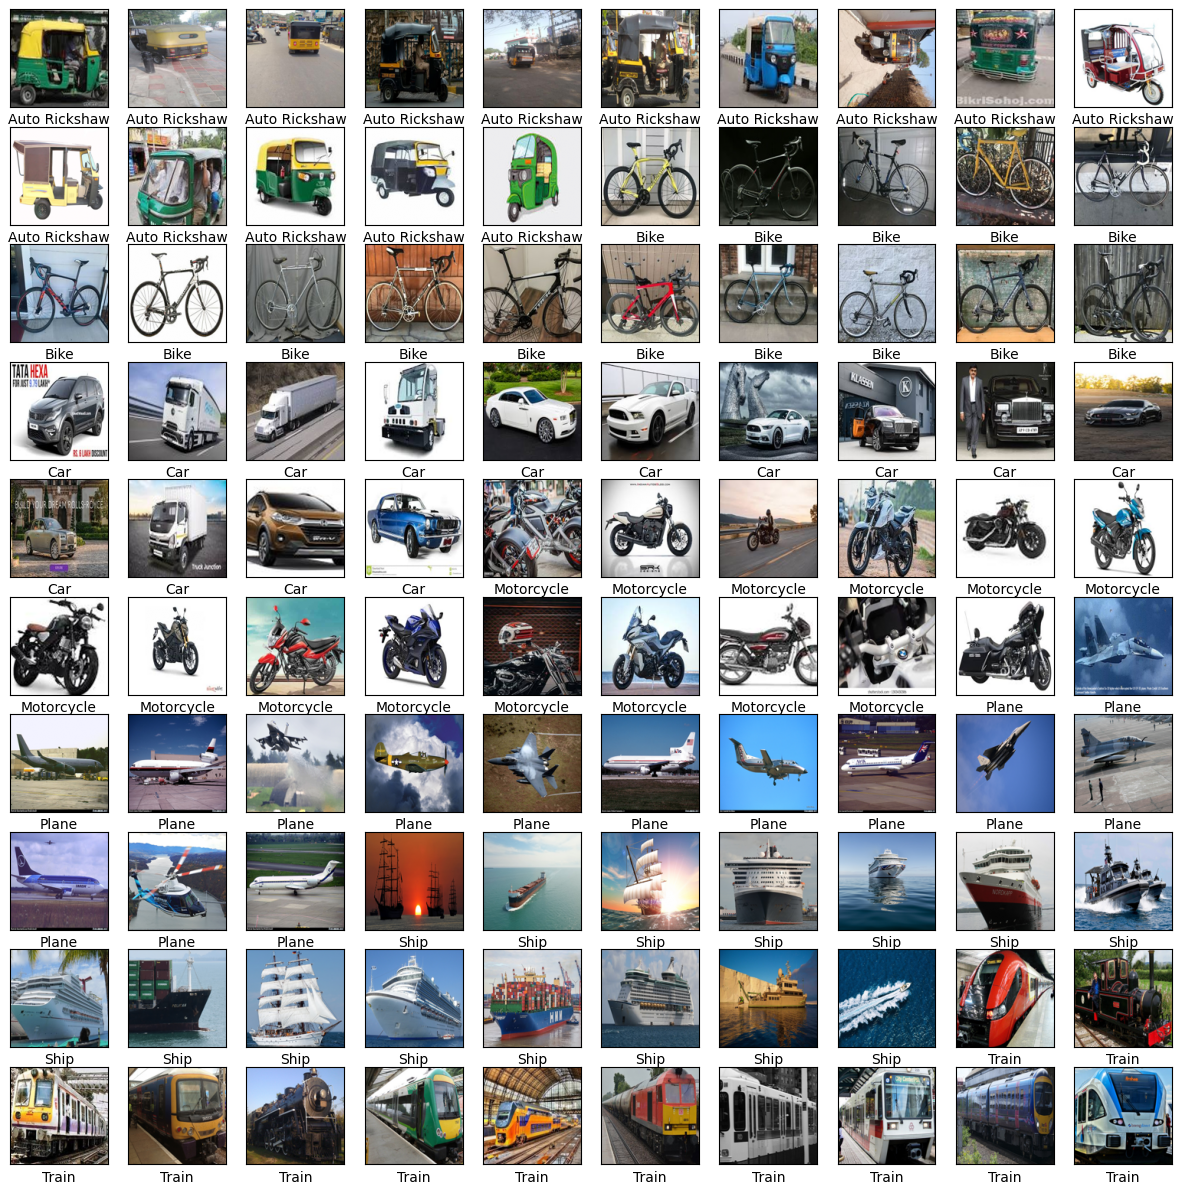

In [6]:
plt.figure(figsize=(15,15))
for i,j in zip(range(0,len(images),len(images)//100), tqdm(range(100))):
    plt.subplot(10,10,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(labels[i])
plt.show()

## Filter images (some have 4 channels, some have 0)

In [7]:
filtered_images = []
filtered_labels = []

In [8]:
for i in range(len(images)):
  if images[i].shape == (128, 128, 3):
    filtered_images.append(images[i])
    filtered_labels.append(labels[i])

In [9]:
df = pd.DataFrame({
    "image": filtered_images,
    "label": filtered_labels
})

In [10]:
df = df[df["image"].notnull()]
x = np.stack(df["image"].values)  # Stack images into a numpy array
y = df["label"].factorize()[0]  # Convert categorical labels to integers

dataset = tf.data.Dataset.from_tensor_slices((x, y))

# Shuffle and batch the data
batch_size = 32
dataset = dataset.shuffle(buffer_size=len(x)).batch(batch_size)

# Repeat dataset for training
dataset = dataset.repeat()

## Split into train, validation and test

In [11]:
# Split into training and validation datasets
train_size = int(0.8 * len(x))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

steps_per_epoch = train_size // batch_size  # Calculate steps per epoch
validation_steps = (len(x) - train_size) // batch_size  # Validation steps

## Create model

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (4, 4), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (4, 4), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(7))

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 125, 125, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 59, 59, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,870,631 (7.14 MB)

 Trainable params: 1,870,631 (7.14 MB)

 Non-trainable params: 0 (0.00 B)

## Plot model

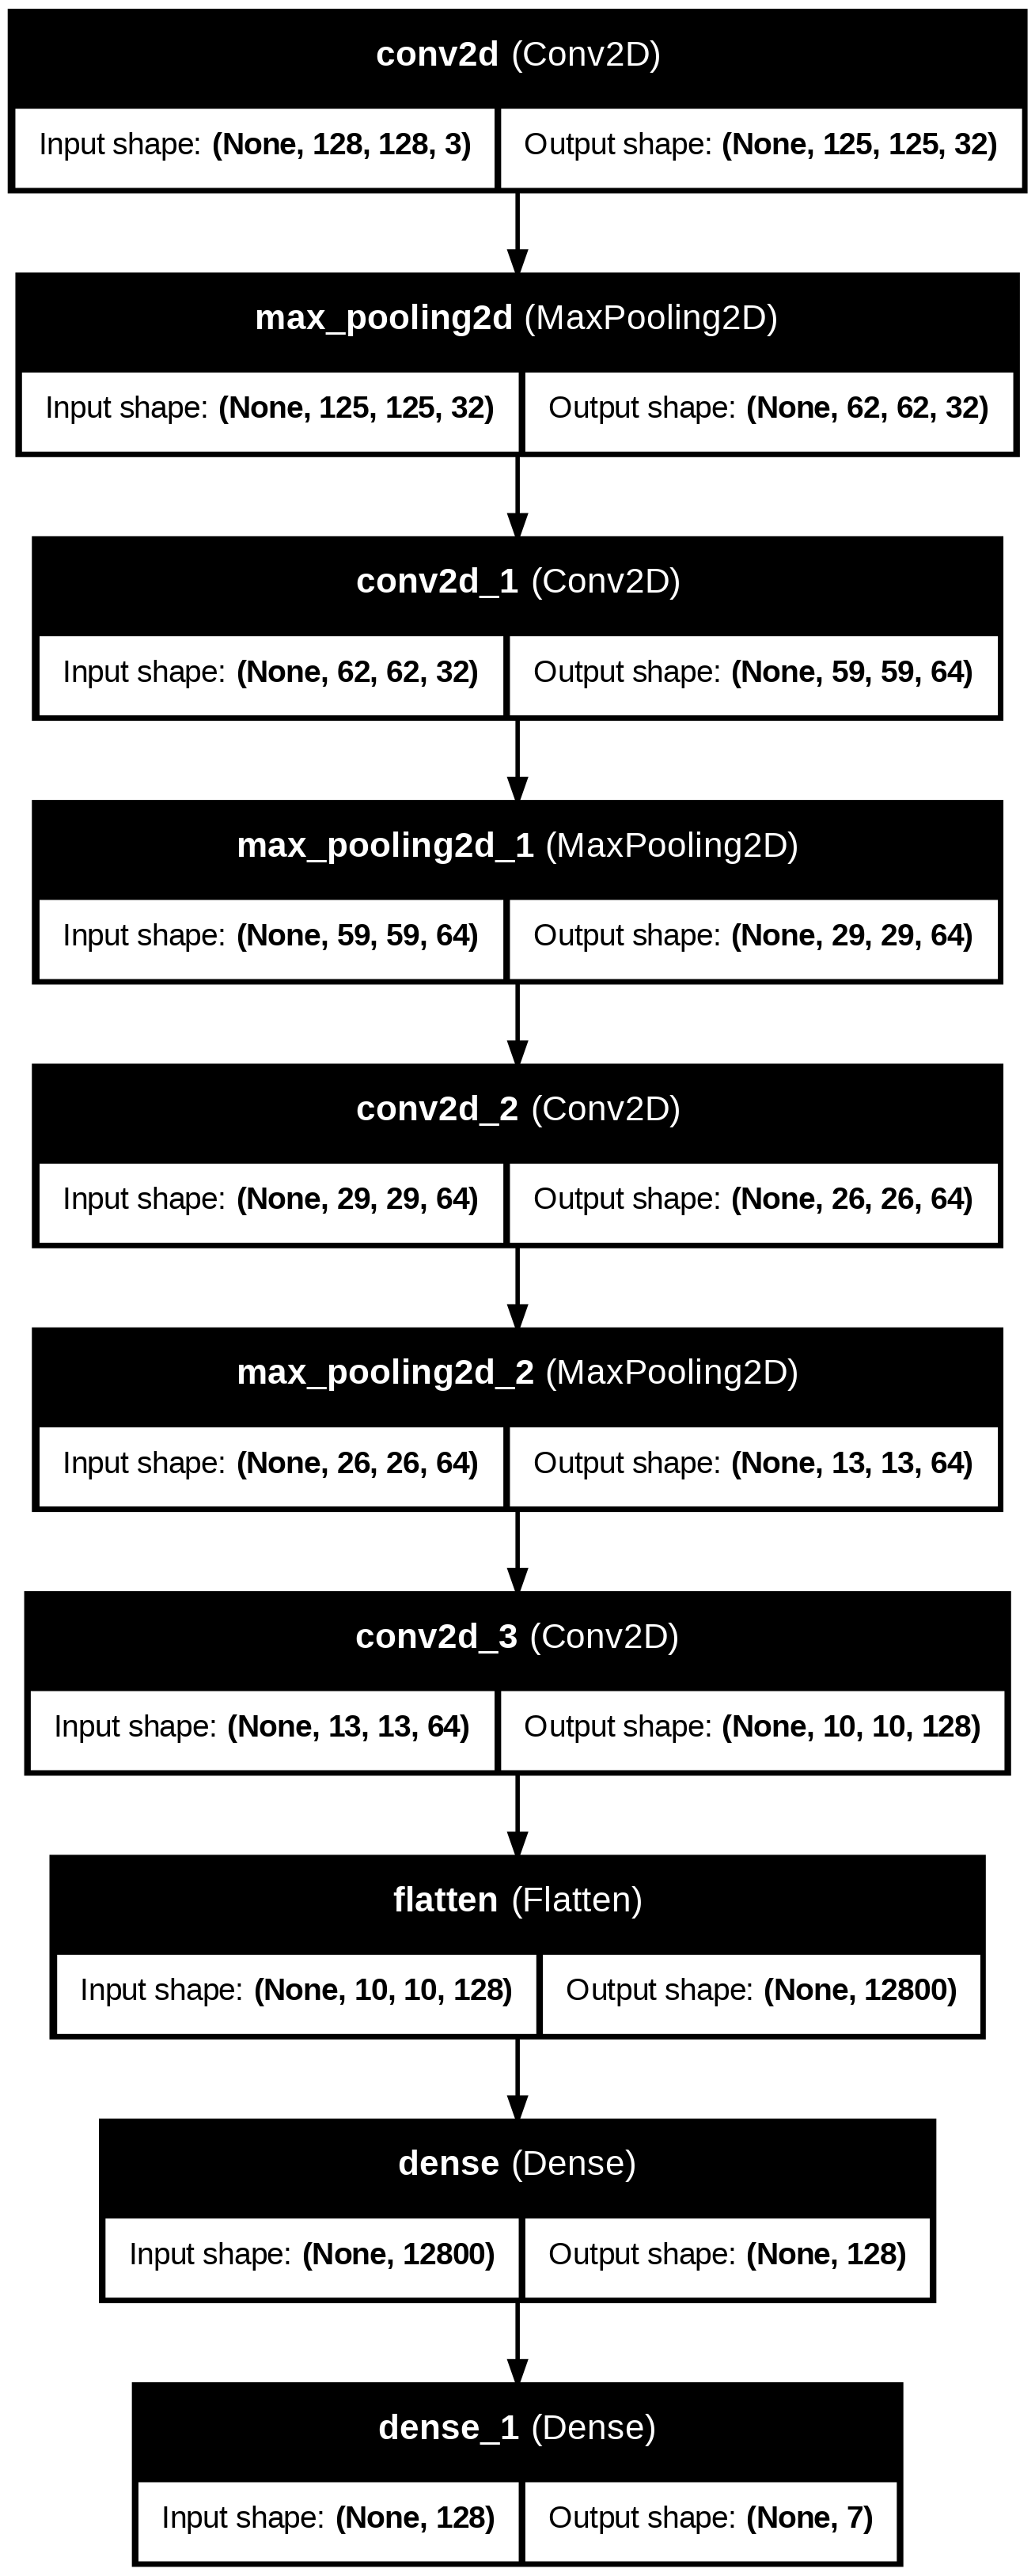

In [13]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Train and evaluate model, show model accuracy over epochs
*Highly recommend using a GPU runtime for this. If you use CPU, expect around 2 minutes per epoch*

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.3357 - loss: 1.6499 - val_accuracy: 0.6388 - val_loss: 0.9971
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6834 - loss: 0.9247 - val_accuracy: 0.7463 - val_loss: 0.7238
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7542 - loss: 0.7241 - val_accuracy: 0.7707 - val_loss: 0.6565
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7831 - loss: 0.6228 - val_accuracy: 0.8401 - val_loss: 0.4568
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8287 - loss: 0.5109 - val_accuracy: 0.8925 - val_loss: 0.3134
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8643 - loss: 0.4159 - val_accuracy: 0.9044 - val_loss: 0.2751
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8859 - loss: 0.3450 - val_accuracy: 0.9366 - val_loss: 0.2003
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9097 - loss: 0.2730 - val_acc

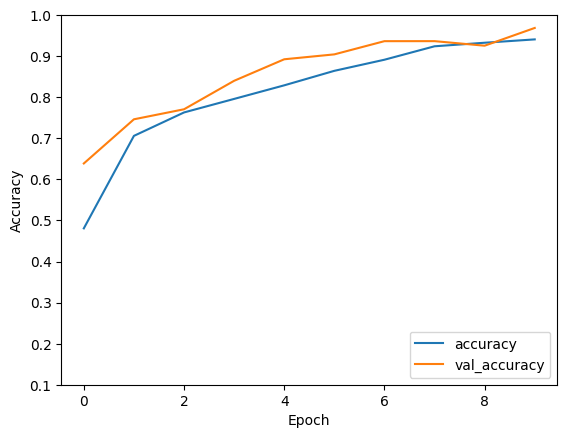

34/34 - 7s - 215ms/step - accuracy: 0.9678 - loss: 0.0941
0.9678308963775635


In [14]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=10,
          steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_dataset, steps=validation_steps, verbose = 2)
print(test_acc)

## Multilayer Perceptron (MLP)

In [15]:
model_perceptron = models.Sequential()
model_perceptron.add(layers.Flatten(input_shape=(128, 128, 3)))
model_perceptron.add(layers.Dense(32, activation='relu'))
model_perceptron.add(layers.Dense(64, activation='relu'))
model_perceptron.add(layers.Dense(64, activation='relu'))
model_perceptron.add(layers.Dense(64, activation='relu'))
model_perceptron.add(layers.Dense(7))

model_perceptron.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  metrics=['accuracy'])

model_perceptron.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │       1,572,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,583,783 (6.04 MB)

 Trainable params: 1,583,783 (6.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.1977 - loss: 2.7077 - val_accuracy: 0.3667 - val_loss: 1.5991
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3822 - loss: 1.5786 - val_accuracy: 0.4513 - val_loss: 1.4037
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3997 - loss: 1.5761 - val_accuracy: 0.4017 - val_loss: 1.4794
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4402 - loss: 1.4241 - val_accuracy: 0.5028 - val_loss: 1.3208
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4679 - loss: 1.3882 - val_accuracy: 0.4660 - val_loss: 1.4288
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4850 - loss: 1.3694 - val_accuracy: 0.4053 - val_loss: 1.5965
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4745 - loss: 1.4200 - val_accuracy: 0.4568 - val_loss: 1.4355
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5110 - loss: 1.3000 - val_accur

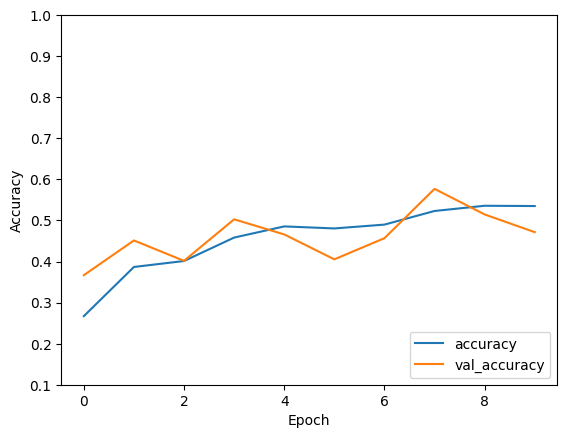

34/34 - 7s - 204ms/step - accuracy: 0.4632 - loss: 1.4419
0.4632352888584137


In [16]:
history = model_perceptron.fit(train_dataset, validation_data=test_dataset, epochs=10,
          steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model_perceptron.evaluate(test_dataset, steps=validation_steps, verbose = 2)
print(test_acc)

# Part 2

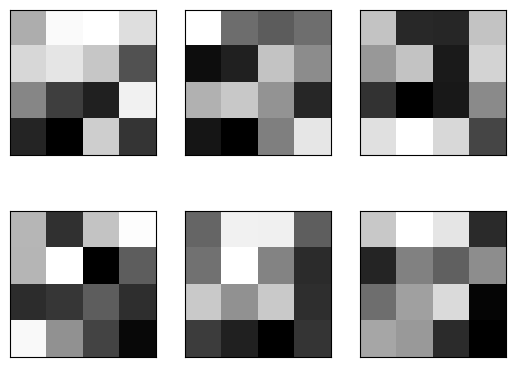

In [17]:
filters, biases = model.layers[0].get_weights()

ix = 1
for filter_i in range(2):
	filter_tmp = filters[:, :, :, filter_i]
	for channel_j in range(3):  # plot each channel separately
		ax = plt.subplot(2, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		plt.imshow(filter_tmp[:, :, channel_j], cmap='gray')
		ix += 1
plt.show()

In [18]:
model_layers_0 = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)  # redefine model to output right after the first hidden layer

In [19]:

img = images[2]  # load the image
img = np.expand_dims(img, axis=0)  # expand dimensions so that it represents a single 'sample'


feature_maps = model_layers_0.predict(img)  # get feature map for first hidden layer
img = images[2]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


In [20]:
transposed_img = np.transpose(img , (2, 0, 1))
np.set_printoptions(threshold=np.inf)
for row in transposed_img[0]:
    formatted_row = ["{:0.2f}".format(element) for element in row]
    print(" ".join(formatted_row))

0.31 0.31 0.31 0.32 0.32 0.31 0.31 0.30 0.31 0.32 0.29 0.20 0.29 0.36 0.33 0.34 0.39 0.38 0.40 0.37 0.38 0.44 0.40 0.33 0.25 0.31 0.33 0.37 0.46 0.58 0.57 0.53 0.53 0.39 0.34 0.36 0.34 0.45 0.45 0.37 0.31 0.26 0.25 0.27 0.27 0.29 0.30 0.28 0.31 0.24 0.18 0.19 0.16 0.18 0.25 0.30 0.23 0.26 0.49 0.97 0.63 0.14 0.15 0.14 0.26 0.21 0.13 0.14 0.17 0.19 0.28 0.27 0.32 0.30 0.34 0.27 0.29 0.22 0.31 0.38 0.40 0.31 0.46 0.29 0.18 0.20 0.20 0.37 0.41 0.38 0.33 0.38 0.36 0.35 0.42 0.51 0.35 0.19 0.23 0.18 0.18 0.24 0.36 0.42 0.32 0.28 0.29 0.23 0.24 0.27 0.23 0.29 0.23 0.17 0.18 0.24 0.42 0.40 0.36 0.34 0.36 0.26 0.25 0.30 0.27 0.35 0.35 0.35
0.24 0.24 0.24 0.23 0.24 0.24 0.24 0.24 0.22 0.21 0.31 0.36 0.40 0.38 0.52 0.55 0.57 0.48 0.49 0.49 0.41 0.31 0.25 0.27 0.33 0.36 0.40 0.58 0.44 0.65 0.63 0.40 0.42 0.39 0.36 0.34 0.27 0.40 0.42 0.39 0.32 0.26 0.24 0.25 0.27 0.28 0.29 0.28 0.30 0.25 0.19 0.19 0.17 0.13 0.24 0.21 0.29 0.33 0.60 0.94 0.67 0.21 0.17 0.16 0.16 0.16 0.16 0.16 0.24 0.21 0.29 0.18 

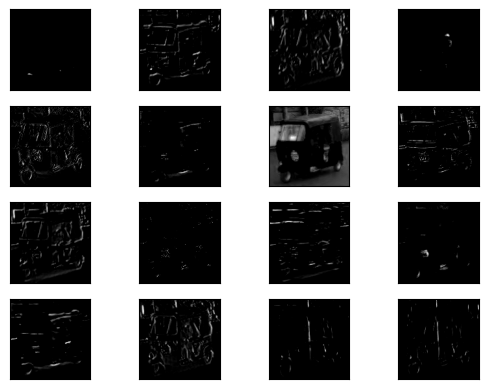

In [21]:
ix = 1
for _ in range(4):
  for _ in range(4):
    if ix > 32:
      break
    # specify subplot and turn of axis
    ax = plt.subplot(4, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1

In [22]:
img.shape

(128, 128, 3)

In [23]:
filter = filters[:,:,:,2]
filter.shape

(4, 4, 3)

In [24]:
bias = biases[2]
bias

-0.0046891384

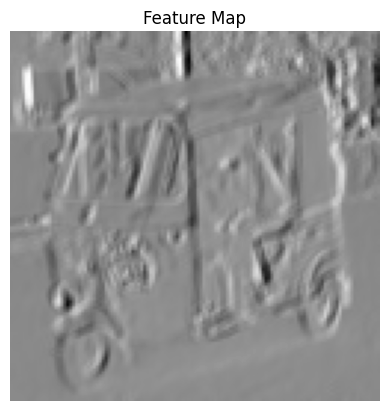

In [25]:
input_image = img

# Perform convolution
feature_map = np.zeros((input_image.shape[0] - filter.shape[0] + 1, input_image.shape[1] - filter.shape[1] + 1))
for i in range(feature_map.shape[0]):
    for j in range(feature_map.shape[1]):
        feature_map[i, j] = np.sum(input_image[i:i+filter.shape[0], j:j+filter.shape[1], :] * filter)

# Display the feature map
plt.imshow(feature_map, cmap='gray')
plt.title("Feature Map")
plt.axis('off')
plt.show()

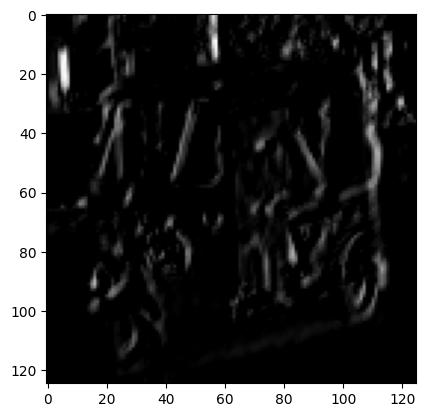

In [26]:
plt.imshow(feature_maps[0, :, :, 2], cmap='gray')
plt.show()

In [27]:
print(feature_map.shape)
print(feature_map[:6,:6])

(125, 125)
[[-0.01369858 -0.0100632  -0.01097262 -0.01146998 -0.0142185  -0.01671609]
 [-0.00930328 -0.00754017 -0.00497847 -0.00215419  0.00187278 -0.00298203]
 [-0.0075114  -0.00884578 -0.0061594  -0.00029797  0.00493279  0.00133112]
 [-0.00898416 -0.00844978 -0.00628433 -0.00035743  0.00900663 -0.00194882]
 [-0.00768415 -0.00679896 -0.00788203 -0.00273811  0.00141968 -0.01206214]
 [-0.00865027 -0.00681228 -0.00862564 -0.00285111 -0.01066885 -0.02048351]]
